In [25]:
from tensorflow.keras.utils import Sequence
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math

class DatasetSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        
        aug = self.augment(image=batch_x[0])
        new_batch = []  
        
        for x, img in enumerate(batch_x):
            new_batch.append(self.augment.replay(saved_augmentations=aug['replay'], image=img)["image"])
            
        return np.stack(new_batch, axis=0), np.array(batch_y)
        #return np.stack(batch_x, axis=0), np.array(batch_y)

In [9]:

import glob
import os
import cv2

import numpy as np

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

#image_shape=(200, 66)
image_shape=(100, 50)

def get_images(list_images, type_image):
    # Read the images
    array_imgs = []
    for name in list_images:
        img = cv2.imread(name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if type_image == 'cropped':
            img = img[240:480, 0:640]
        #img = cv2.resize(img, (int(img.shape[1] / 4), int(img.shape[0] / 4)))
        img = cv2.resize(img, image_shape)
        array_imgs.append(img)

    return array_imgs

def parse_json(data):
    # Process json
    array_annotations_v = []
    array_annotations_w = []
    array = []
    data_parse = data.split('}')[:-1]

    for number, d in enumerate(data_parse):
        v = d.split('"v": ')[1]
        d_parse = d.split(', "v":')[0]
        w = d_parse.split(('"w": '))[1]
        array_annotations_v.append(float(v))
        array_annotations_w.append(float(w))
        array.append((float(v), float(w)))
    return array

def flip_images(images, array_annotations):
    flipped_images = []
    flipped_annotations = []
    for i, image in enumerate(images):
        flipped_images.append(cv2.flip(image, 1))
        flipped_annotations.append((array_annotations[i][0], -array_annotations[i][1]))
        #flipped_image = FLIP_AUGMENTATION(image=image)['image']
        #flipped_images.append(flipped_image)
        #flipped_annotations.append([array_annotations[i][0], 1-array_annotations[i][1]])
    
    images += flipped_images
    array_annotations += flipped_annotations
    return images, array_annotations

'''
def add_extreme_data(images, array_annotations):
    for i in range(0, len(array_annotations)):
        if abs(array_annotations[i][1]) >= 1:
            if abs(array_annotations[i][1]) >= 2:
                # num_iter = 10
                num_iter = 15
            else:
                # num_iter = 5
                num_iter = 10
            for j in range(0, num_iter):
                array_annotations.append(array_annotations[i])
                images.append(images[i])
        if float(array_annotations[i][0]) <= 2:
            for j in range(0, 1):
                array_annotations.append(array_annotations[i])
                images.append(images[i])
    return images, array_annotations
'''
def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))

print('---- Complete ----')
complete_name_file = '../complete_dataset/data.json'
complete_file = open(complete_name_file, 'r')
data_complete = complete_file.read()
complete_file.close()

array_annotations_complete = []
DIR_complete_images = '../complete_dataset/Images/'
list_images_complete = glob.glob(DIR_complete_images + '*')
images_paths_complete = sorted(list_images_complete, key=lambda x: int(x.split('/')[3].split('.png')[0]))
#print(images_paths_complete)
array_annotations_complete = parse_json(data_complete)

images_complete = get_images(images_paths_complete, 'cropped')
images_complete, array_annotations_complete = flip_images(images_complete, array_annotations_complete)
print(len(images_complete))
print(type(images_complete))
print(len(array_annotations_complete))
#images_complete, array_annotations_complete = add_extreme_data(images_complete, array_annotations_complete)
#print(len(images_complete))
#print(type(images_complete))
#print(len(array_annotations_complete))

array_annotations_v = []
array_annotations_w = []
for annotation in array_annotations_complete:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])
    
# START NORMALIZE DATA
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

normalized_X = normalize(array_annotations_v)
normalized_Y = normalize(array_annotations_w)

normalized_annotations = []
for i in range(0, len(normalized_X)):
    normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])
    
array_annotations_complete = normalized_annotations

print(len(images_complete))
print(type(images_complete))
print(len(array_annotations_complete))


print('---- Curves ----')
curves_name_file = '../curves_only/data.json'
file_curves = open(curves_name_file, 'r')
data_curves = file_curves.read()
file_curves.close()

DIR_curves_images = '../curves_only/Images/'
list_images_curves = glob.glob(DIR_curves_images + '*')
images_paths_curves = sorted(list_images_curves, key=lambda x: int(x.split('/')[3].split('.png')[0]))
array_annotations_curves = parse_json(data_curves)

images_curves = get_images(images_paths_curves, 'cropped')
images_curves, array_annotations_curves = flip_images(images_curves, array_annotations_curves)
print(len(images_curves))
print(type(images_curves))
print(len(array_annotations_curves))
#images_curves, array_annotations_curves = add_extreme_data(images_curves, array_annotations_curves)
#print(len(images_curves))
#print(type(images_curves))
#print(len(array_annotations_curves))

array_annotations_v = []
array_annotations_w = []
for annotation in array_annotations_curves:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])
    
# START NORMALIZE DATA
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

normalized_X = normalize(array_annotations_v)
normalized_Y = normalize(array_annotations_w)

normalized_annotations = []
for i in range(0, len(normalized_X)):
    normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])
    
array_annotations_curves = normalized_annotations

print(len(images_curves))
print(type(images_curves))
print(len(array_annotations_curves))

---- Complete ----
34682
<class 'list'>
34682
34682
<class 'list'>
34682
---- Curves ----
10536
<class 'list'>
10536
10536
<class 'list'>
10536


--- COMPLETE DATA ---


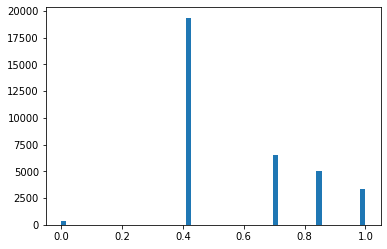

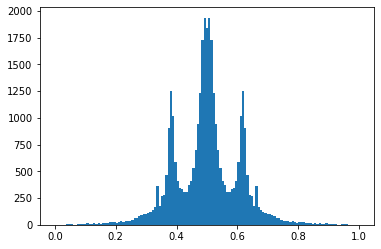

--- CURVES DATA ---


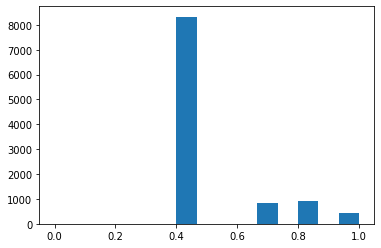

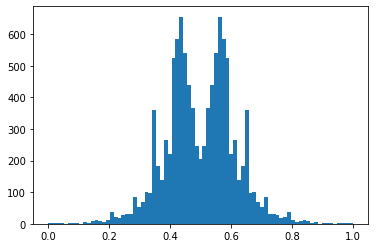

In [10]:
print('--- COMPLETE DATA ---')
ann_x = []
ann_y = []
for ann in array_annotations_complete:
    ann_x.append(ann[0])
    ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()

print('--- CURVES DATA ---')
ann_x = []
ann_y = []
for ann in array_annotations_curves:
    ann_x.append(ann[0])
    ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()

[1.0, 0.5047369773267391]
[1.0, 0.49526302267326094]


<Figure size 432x288 with 0 Axes>

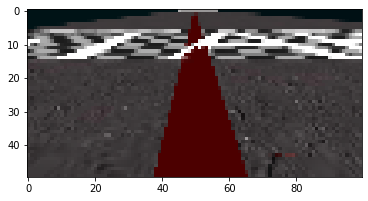

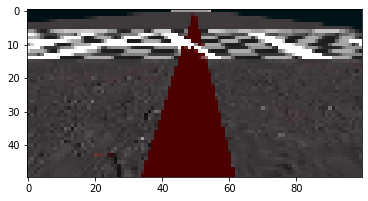

<Figure size 432x288 with 0 Axes>

In [11]:
for x in range(0,0):
    plt.imshow(images_complete[x])
    print(array_annotations_complete[x])
    plt.figure()
    
    
plt.imshow(images_complete[0])
print(array_annotations_complete[0])
plt.figure()
plt.imshow(images_complete[17341])
print(array_annotations_complete[17341])
plt.figure()

In [12]:
array_imgs = images_complete + images_curves
array_annotations = array_annotations_complete + array_annotations_curves


In [13]:
# SEPARATE DATASET INTO SEQUENCES TO FIT BATCH SIZES
# 1
array_1_img = [] 
array_1_ann = []
# 2
array_2_img = [] 
array_2_ann = []
# 3
array_3_img = [] 
array_3_ann = []
# 4
array_4_img = [] 
array_4_ann = []
# 5
array_5_img = [] 
array_5_ann = []
# 6
array_6_img = [] 
array_6_ann = []
# 7
array_7_img = [] 
array_7_ann = []
# 8
array_8_img = [] 
array_8_ann = []
# 9
array_9_img = [] 
array_9_ann = []
# 10
array_10_img = [] 
array_10_ann = []
# 11
array_11_img = [] 
array_11_ann = []
# 12
array_12_img = [] 
array_12_ann = []
# 13
array_13_img = [] 
array_13_ann = []
# 14
array_14_img = [] 
array_14_ann = []
# 15
array_15_img = [] 
array_15_ann = []
# 16
array_16_img = [] 
array_16_ann = []
# 17
array_17_img = [] 
array_17_ann = []
# 18
array_18_img = [] 
array_18_ann = []
# 19
array_19_img = [] 
array_19_ann = []
# 20
array_20_img = [] 
array_20_ann = []
# 21
array_21_img = [] 
array_21_ann = []
# 22
array_22_img = [] 
array_22_ann = []
# 23
array_23_img = [] 
array_23_ann = []
# 24
array_24_img = [] 
array_24_ann = []
# 25
array_25_img = [] 
array_25_ann = []
# 26
array_26_img = [] 
array_26_ann = []
# 27
array_27_img = [] 
array_27_ann = []
# 28
array_28_img = [] 
array_28_ann = []
# 29
array_29_img = [] 
array_29_ann = []
# 30
array_30_img = [] 
array_30_ann = []
# 31
array_31_img = [] 
array_31_ann = []
# 32
array_32_img = [] 
array_32_ann = []
# 33
array_33_img = [] 
array_33_ann = []


'''
Dataset completo:

3744-3745
5066-5067
9720-9721
10387-10388
10695-10696
11283-11284
11354-11355
11492-11493
11980-11981
12618-12619
13231-13232
14107-14108
15790-15791
16732-16762 -> giro total???
16795-16796
16796-17341
Dataset muchas curvas:
(17341+...)
3156-3157

Cortes: 
1. 0-3700 *
2. 3745-5045 *
3. 5067-9717 *
4. 9721-10371 *
5. 10388-10688 *
6. 10696-11246 *
7. 11284-11334 *
8. 11355-11455 *
9. 11493-11943 *
10. 11981-12581 *
11. 12619-13219 *
12. 13232-14082 *
13. 14108-15758 *
14. 15791-16691 *
15. 16796-17296 *
16. 17341-20491 *
17. 20498-22598 *
Repetición cortes:
1. 22609-26309 *
2. 26354-27654 *
3. 27676-32326 *
4. 32330-32960 *
5. 32997-33297 *
6. 33305-33855 *
7. 33893-33943 *
8. 33964-34064 *
9. 34102-34552 *
10. 34590-35190 *
11. 35228-35828 *
12. 35841-36691 *
13. 36717-38367 *
14. 38400-39300 *
15. 39405-39905 *
16. 39950-43100 *
17. 43107-45207 *


'''


for i in range(0, 3700):
    array_1_img.append(array_imgs[i])
    array_1_ann.append(array_annotations[i])
for i in range(3745, 5045):
    array_2_img.append(array_imgs[i])
    array_2_ann.append(array_annotations[i])
for i in range(5067, 9717):
    array_3_img.append(array_imgs[i])
    array_3_ann.append(array_annotations[i])
for i in range(9721, 10371):
    array_4_img.append(array_imgs[i])
    array_4_ann.append(array_annotations[i])
for i in range(10388, 10688):
    array_5_img.append(array_imgs[i])
    array_5_ann.append(array_annotations[i])
for i in range(10696, 11246):
    array_6_img.append(array_imgs[i])
    array_6_ann.append(array_annotations[i])
for i in range(11284, 11334):
    array_7_img.append(array_imgs[i])
    array_7_ann.append(array_annotations[i])
for i in range(11355, 11455):
    array_8_img.append(array_imgs[i])
    array_8_ann.append(array_annotations[i])
for i in range(11493, 11943):
    array_9_img.append(array_imgs[i])
    array_9_ann.append(array_annotations[i])
for i in range(11981, 12581):
    array_10_img.append(array_imgs[i])
    array_10_ann.append(array_annotations[i])
for i in range(12619, 13219):
    array_11_img.append(array_imgs[i])
    array_11_ann.append(array_annotations[i])
for i in range(13232, 14082):
    array_12_img.append(array_imgs[i])
    array_12_ann.append(array_annotations[i])
for i in range(14108, 15758):
    array_13_img.append(array_imgs[i])
    array_13_ann.append(array_annotations[i])
#for i in range(15791, 17296):
for i in range(15791, 17291):
    array_14_img.append(array_imgs[i])
    array_14_ann.append(array_annotations[i])
for i in range(17341, 20491):
    array_15_img.append(array_imgs[i])
    array_15_ann.append(array_annotations[i])
for i in range(20498, 22598):
    array_16_img.append(array_imgs[i])
    array_16_ann.append(array_annotations[i])
for i in range(22609, 26309):
    array_17_img.append(array_imgs[i])
    array_17_ann.append(array_annotations[i])
for i in range(26354, 27654):
    array_18_img.append(array_imgs[i])
    array_18_ann.append(array_annotations[i])
for i in range(27676, 32326):
    array_19_img.append(array_imgs[i])
    array_19_ann.append(array_annotations[i])
#for i in range(32330, 32960):
for i in range(32330, 32930):
    array_20_img.append(array_imgs[i])
    array_20_ann.append(array_annotations[i])
for i in range(32997, 33297):
    array_21_img.append(array_imgs[i])
    array_21_ann.append(array_annotations[i])
for i in range(33305, 33855):
    array_22_img.append(array_imgs[i])
    array_22_ann.append(array_annotations[i])
for i in range(33893, 33943):
    array_23_img.append(array_imgs[i])
    array_23_ann.append(array_annotations[i])
for i in range(33964, 34064):
    array_24_img.append(array_imgs[i])
    array_24_ann.append(array_annotations[i])
for i in range(34102, 34552):
    array_25_img.append(array_imgs[i])
    array_25_ann.append(array_annotations[i])
for i in range(34590, 35190):
    array_26_img.append(array_imgs[i])
    array_26_ann.append(array_annotations[i])
for i in range(35228, 35828):
    array_27_img.append(array_imgs[i])
    array_27_ann.append(array_annotations[i])
for i in range(35841, 36691):
    array_28_img.append(array_imgs[i])
    array_28_ann.append(array_annotations[i])
for i in range(36717, 38367):
    array_29_img.append(array_imgs[i])
    array_29_ann.append(array_annotations[i])
for i in range(38400, 39300):
    array_30_img.append(array_imgs[i])
    array_30_ann.append(array_annotations[i])
for i in range(39405, 39905):
    array_31_img.append(array_imgs[i])
    array_31_ann.append(array_annotations[i])
for i in range(39950, 43100):
    array_32_img.append(array_imgs[i])
    array_32_ann.append(array_annotations[i])
#for i in range(43107, 45202):
for i in range(43107, 45157):
    array_33_img.append(array_imgs[i])
    array_33_ann.append(array_annotations[i])


'''
[21, 0, 12, 2, 10, 26, 25, 7, 29, 15, 30, 28, 27, 3, 4, 24, 32, 6, 19, 8, 20, 14, 17, 16, 31, 13, 9, 1, 5, 18, 22, 11, 23]
'''

array_x = []
array_x.append(array_1_img)
array_x.append(array_2_img)
array_x.append(array_3_img)
array_x.append(array_4_img)
array_x.append(array_5_img)
array_x.append(array_6_img)
array_x.append(array_7_img)
array_x.append(array_8_img)
array_x.append(array_9_img)
array_x.append(array_10_img)
array_x.append(array_11_img)
array_x.append(array_12_img)
#array_x.append(array_13_img)
#array_x.append(array_14_img)
array_x.append(array_13_img)
array_x.append(array_14_img)
array_x.append(array_15_img)
array_x.append(array_16_img)
array_x.append(array_17_img)
array_x.append(array_18_img)
array_x.append(array_19_img)
array_x.append(array_20_img)
array_x.append(array_21_img)
array_x.append(array_22_img)
array_x.append(array_23_img)
array_x.append(array_24_img)
array_x.append(array_25_img)
array_x.append(array_26_img)
array_x.append(array_27_img)
array_x.append(array_28_img)
#array_x.append(array_29_img)
#array_x.append(array_30_img)
#array_x.append(array_31_img)
array_x.append(array_29_img)
array_x.append(array_30_img)
array_x.append(array_31_img)
array_x.append(array_32_img)
array_x.append(array_33_img)


array_y = []
array_y.append(array_1_ann)
array_y.append(array_2_ann)
array_y.append(array_3_ann)
array_y.append(array_4_ann)
array_y.append(array_5_ann)
array_y.append(array_6_ann)
array_y.append(array_7_ann)
array_y.append(array_8_ann)
array_y.append(array_9_ann)
array_y.append(array_10_ann)
array_y.append(array_11_ann)
array_y.append(array_12_ann)
#array_y.append(array_13_ann)
#array_y.append(array_14_ann)
array_y.append(array_13_ann)
array_y.append(array_14_ann)
array_y.append(array_15_ann)
array_y.append(array_16_ann)
array_y.append(array_17_ann)
array_y.append(array_18_ann)
array_y.append(array_19_ann)
array_y.append(array_20_ann)
array_y.append(array_21_ann)
array_y.append(array_22_ann)
array_y.append(array_23_ann)
array_y.append(array_24_ann)
array_y.append(array_25_ann)
array_y.append(array_26_ann)
array_y.append(array_27_ann)
array_y.append(array_28_ann)
#array_y.append(array_29_ann)
#array_y.append(array_30_ann)
#array_y.append(array_31_ann)
array_y.append(array_29_ann)
array_y.append(array_30_ann)
array_y.append(array_31_ann)
array_y.append(array_32_ann)
array_y.append(array_33_ann)

print(len(array_x))
print(len(array_y))

33
33


363
44200


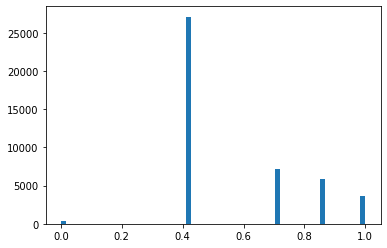

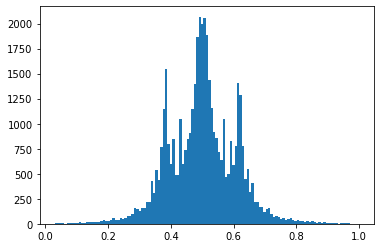

In [14]:
shown_array_annotations = []
for numb in range(0, 33):
    shown_array_annotations += array_y[numb]
    
ann_x = []
ann_y = []
number = 0 
total_number = 0
for x, ann in enumerate(shown_array_annotations):
    ann_x.append(ann[0])
    ann_y.append(ann[1])
    if float(ann[0]) <= 0.2:
        #print(x)
        number += 1
    total_number += 1
print(number)
print(total_number)

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()

3700
7400
7400
----
1300
3350
3350
----
4650
8750
8750
----
650
4850
4850
----
300
3050
3050
----
550
4300
4300
----
50
50
50
----
100
1050
1050
----
450
3600
3600
----
600
5200
5200
----
600
4850
4850
----
850
7000
7000
----
1650
16350
16350
----
1500
14650
14650
----
3150
5600
5600
----
2100
5400
5400
----
3700
7050
7050
----
1300
6000
6000
----
4650
39950
39950
----
600
6050
6050
----
300
3550
3550
----
550
5050
5050
----
50
50
50
----
100
600
600
----
450
4650
4650
----
600
900
900
----
600
600
600
----
850
4850
4850
----
1650
12450
12450
----
900
2350
2350
----
500
1750
1750
----
3150
13000
13000
----
2050
10700
10700
----
------
7400
33
[28, 32, 0, 18, 6, 1, 15, 12, 22, 14, 9, 8, 29, 19, 31, 20, 10, 4, 26, 17, 16, 23, 13, 24, 30, 25, 7, 5, 11, 3, 27, 2, 21]
215000
215000
6143
215000


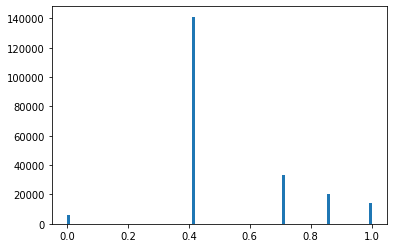

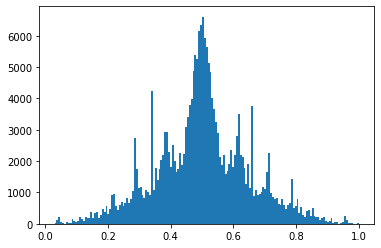

In [15]:
'''
Look for extreme 50 frames sequences inside every big-sequence
'''
new_array_x = []
new_array_y = []
for x, big_sequence_anns in enumerate(array_y):
    new_big_sequence_imgs = []
    new_big_sequence_anns = []
    print(len(big_sequence_anns))
    for y in range(0, int(len(big_sequence_anns)/50)):
        sequences_imgs = array_x[x][y*50:(y*50)+50]
        sequences_anns = array_y[x][y*50:(y*50)+50]
        #sequences_anns = big_sequence_anns[y*50:(y*50)+50]
        new_big_sequence_imgs+=sequences_imgs
        new_big_sequence_anns+=sequences_anns
        for seq in sequences_anns:
            if seq[1] >= 0.7 or seq[1] <= 0.3:
                if seq[1] >= 0.8 or seq[1] <= 0.2:
                    # Add 10
                    #print(1)
                    for i in range(0,2):
                        new_big_sequence_imgs+=sequences_imgs
                        new_big_sequence_anns+=sequences_anns
                else:
                    # Add 5
                    #print(2)
                    for i in range(0,1):
                        new_big_sequence_imgs+=sequences_imgs
                        new_big_sequence_anns+=sequences_anns
            if seq[0] <= 0.2:
                number +=1
                # Add 1
                #print(3)
                for i in range(0,1):
                    new_big_sequence_imgs+=sequences_imgs
                    new_big_sequence_anns+=sequences_anns
    print(len(new_big_sequence_imgs))
    print(len(new_big_sequence_anns))
    print('----')
    new_array_x.append(new_big_sequence_imgs)
    new_array_y.append(new_big_sequence_anns)
    
print('------')   
#print(len(new_array_x))
#print(len(new_array_y))
print(len(new_array_y[0]))

shown_array_imgs = []
shown_array_annotations = []
import random
random_sort = random.sample(range(0, 33), 33)
print(len(random_sort))
print(random_sort)

new_array_imgs = []
new_array_annotations = []
for numb in random_sort:
    shown_array_imgs += new_array_x[numb]
    shown_array_annotations += new_array_y[numb]
    
print(len(shown_array_imgs))   
print(len(shown_array_annotations))


ann_x = []
ann_y = []
number = 0 
total_number = 0
for x, ann in enumerate(shown_array_annotations):
    ann_x.append(ann[0])
    ann_y.append(ann[1])
    if float(ann[0]) <= 0.2:
        #print(x)
        number += 1
    total_number += 1
print(number)
print(total_number)

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()


array_x = shown_array_imgs
array_y = shown_array_annotations

In [14]:
'''
Instead of creating 3 img-sequences, generate a full new dataset

'''
'''
import random
random_sort = random.sample(range(0, 33), 33)
print(len(random_sort))
print(random_sort)

new_array_imgs = []
new_array_annotations = []
for numb in random_sort:
    new_array_imgs += array_x[numb]
    new_array_annotations += array_y[numb]
'''

33
[14, 19, 30, 28, 29, 11, 8, 23, 7, 22, 24, 3, 26, 15, 21, 25, 6, 10, 9, 27, 16, 4, 17, 0, 20, 5, 32, 1, 12, 13, 18, 2, 31]


In [15]:
'''
new_array_img = []
new_array_ann = []

for x, array_img in enumerate(array_x):
    sequence_array_imgs = []
    sequence_array_anns = []
    x_1 = []
    x_2 = []
    x_3 = []

    for i, image in enumerate(array_img):
        x_1.insert(0, image)
        if i > 0:
            x_2.insert(0, image)
        if i > 1:
            x_3.insert(0, image)

        if len(x_1) == 3:
            sequence_array_imgs.append(x_1)
            x_1 = []
        if len(x_2) == 3:
            sequence_array_imgs.append(x_2)
            x_2 = []
        if len(x_3) == 3:
            sequence_array_imgs.append(x_3)
            x_3 = []

    new_array_img.append(sequence_array_imgs)
    new_array_y = array_y[x]
    new_array_y = new_array_y[2::1]
    new_array_ann.append(new_array_y)

print(len(new_array_img))
print(len(new_array_img[0]))
print(len(new_array_ann))
print(len(new_array_ann[0]))
   
array_x = [new_array_img[0], new_array_img[1], new_array_img[2], new_array_img[3], new_array_img[4], new_array_img[5],
            new_array_img[6], new_array_img[7], new_array_img[8], new_array_img[9], new_array_img[10], new_array_img[11],
            new_array_img[12], new_array_img[13], new_array_img[14], new_array_img[15], new_array_img[16], new_array_img[17],
            new_array_img[18], new_array_img[19], new_array_img[20], new_array_img[21], new_array_img[22], new_array_img[23],
            new_array_img[24], new_array_img[25], new_array_img[26], new_array_img[27]]


array_y = [new_array_ann[0], new_array_ann[1], new_array_ann[2], new_array_ann[3], new_array_ann[4], new_array_ann[5],
            new_array_ann[6], new_array_ann[7], new_array_ann[8], new_array_ann[9], new_array_ann[10], new_array_ann[11],
            new_array_ann[12], new_array_ann[13], new_array_ann[14], new_array_ann[15], new_array_ann[16], new_array_ann[17],
            new_array_ann[18], new_array_ann[19], new_array_ann[20], new_array_ann[21], new_array_ann[22], new_array_ann[23],
            new_array_ann[24], new_array_ann[25], new_array_ann[26], new_array_ann[27]]


import random
random_sort = random.sample(range(0, 28), 28)
print(len(random_sort))
print(random_sort)

new_array_imgs = []
new_array_annotations = []
for numb in random_sort:
    new_array_imgs += array_x[numb]
    new_array_annotations += array_y[numb]
'''

'\nnew_array_img = []\nnew_array_ann = []\n\nfor x, array_img in enumerate(array_x):\n    sequence_array_imgs = []\n    sequence_array_anns = []\n    x_1 = []\n    x_2 = []\n    x_3 = []\n\n    for i, image in enumerate(array_img):\n        x_1.insert(0, image)\n        if i > 0:\n            x_2.insert(0, image)\n        if i > 1:\n            x_3.insert(0, image)\n\n        if len(x_1) == 3:\n            sequence_array_imgs.append(x_1)\n            x_1 = []\n        if len(x_2) == 3:\n            sequence_array_imgs.append(x_2)\n            x_2 = []\n        if len(x_3) == 3:\n            sequence_array_imgs.append(x_3)\n            x_3 = []\n\n    new_array_img.append(sequence_array_imgs)\n    new_array_y = array_y[x]\n    new_array_y = new_array_y[2::1]\n    new_array_ann.append(new_array_y)\n\nprint(len(new_array_img))\nprint(len(new_array_img[0]))\nprint(len(new_array_ann))\nprint(len(new_array_ann[0]))\n   \narray_x = [new_array_img[0], new_array_img[1], new_array_img[2], new_ar

In [16]:
images_train, images_validation, annotations_train, annotations_validation = train_test_split(array_x, array_y, test_size=0.30, random_state=42, shuffle=False)

# Adapt the data
images_train = np.stack(images_train, axis=0)
annotations_train = np.stack(annotations_train, axis=0)
images_validation = np.stack(images_validation, axis=0)
annotations_validation = np.stack(annotations_validation, axis=0)

#print(len(new_array_annotations))
print(annotations_train[0])
print(annotations_train.shape)
print(annotations_validation[0])
print(annotations_validation.shape)

#video = np.stack(array_imgs, axis=0)
print(images_train.shape)
print(images_validation.shape)

[0.41176471 0.40494253]
(150500, 2)
[1.         0.48786049]
(64500, 2)
(150500, 50, 100, 3)
(64500, 50, 100, 3)


[1.         0.48786049]
[1.         0.48786049]
[1.         0.48975528]
[1.        0.4905421]
[1.       0.493304]
[1.         0.49685272]
[1.         0.49842636]
[1.         0.50300276]
[1.         0.50639091]
[0.85294118 0.50950607]
[0.41176471 0.71340484]


<Figure size 432x288 with 0 Axes>

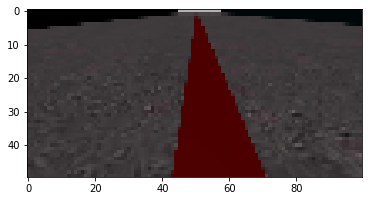

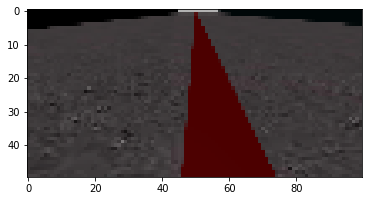

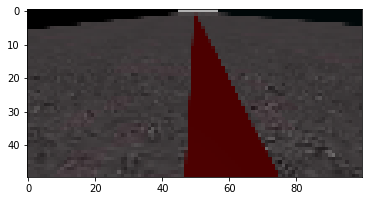

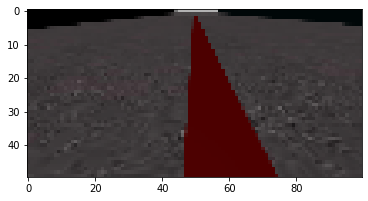

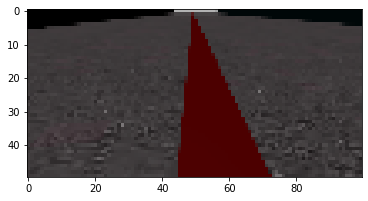

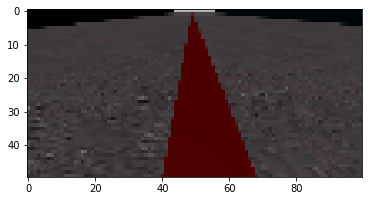

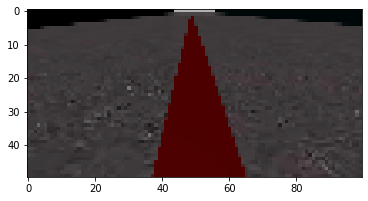

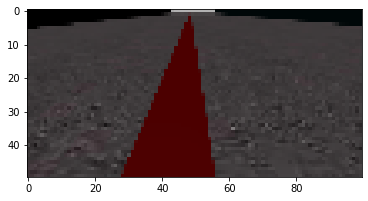

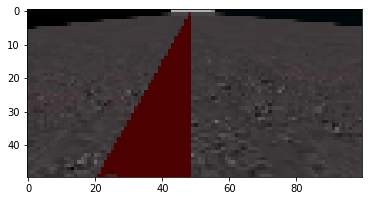

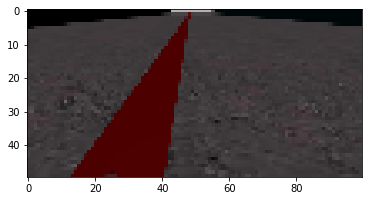

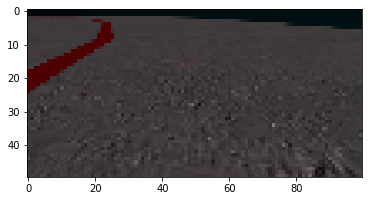

<Figure size 432x288 with 0 Axes>

In [17]:
'''for i in range(100, 105):
    plt.imshow(images_validation[i])
    print(annotations_validation[i])
    plt.figure()'''
'''
plt.imshow(images_validation[0])
print(annotations_validation[0])
plt.figure()
plt.imshow(images_validation[1])
print(annotations_validation[1])
plt.figure()
'''
for i in range(0,10):
    plt.imshow(images_validation[i])
    print(annotations_validation[i])
    plt.figure()
plt.imshow(images_validation[5398])
print(annotations_validation[5398])
plt.figure()

--- ANNOTATIONS DATA ---


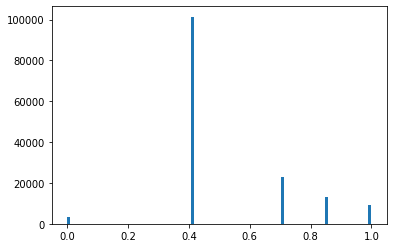

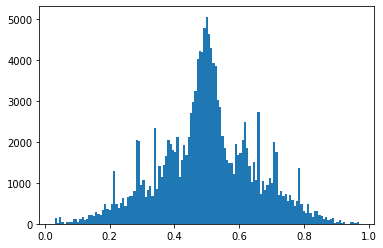

--- VALIDATION DATA ---


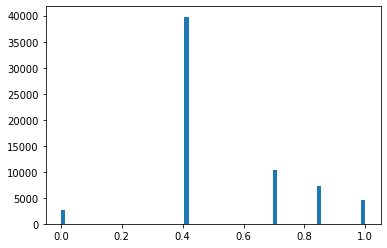

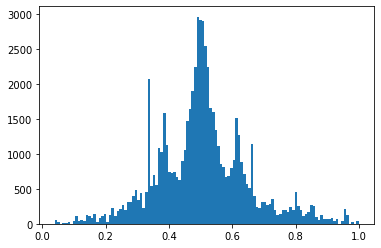

In [18]:
print('--- ANNOTATIONS DATA ---')
ann_x = []
ann_y = []
for ann in annotations_train:
    ann_x.append(ann[0])
    ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()

print('--- VALIDATION DATA ---')
ann_x = []
ann_y = []
for ann in annotations_validation:
    ann_x.append(ann[0])
    ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()

In [26]:
from albumentations import (
    Compose, HorizontalFlip, RandomBrightnessContrast, 
    HueSaturationValue, FancyPCA, RandomGamma, GaussNoise,
    GaussianBlur, ToFloat, Normalize, ColorJitter, ChannelShuffle, Equalize, ReplayCompose
)

AUGMENTATIONS_TRAIN = ReplayCompose([
    RandomBrightnessContrast(),
    HueSaturationValue(),
    FancyPCA(),
    RandomGamma(),
    GaussianBlur(),
    #GaussNoise(),
    #
    #ColorJitter(),
    #Equalize(),
    #ChannelShuffle(),
    #
    Normalize()
])

AUGMENTATIONS_TEST = ReplayCompose([
    Normalize()
])

In [15]:
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Conv2D,BatchNormalization,Dropout,ConvLSTM2D,Reshape,Activation,MaxPooling2D, LSTM, Input
#from tensorflow.keras.layers.wrappers import TimeDistributed
from tensorflow.keras.optimizers import Adam


# PRUEBA SACADA DEL PAPER Self-driving a Car in Simulation Through a CNN
# DEEPEST LSTM tinypilotnet
def deepest_lstm_tinypilotnet_model(img_shape):
    model = Sequential()
    model.add(BatchNormalization(epsilon=0.001, axis=-1, input_shape=img_shape))
    model.add(Conv2D(8, (3, 3), strides=(2, 2), input_shape=img_shape, activation="relu"))
    model.add(Conv2D(8, (3, 3), strides=(2, 2), activation="relu"))
    model.add(Conv2D(8, (3, 3), strides=(2, 2), activation="relu"))
    model.add(Dropout(0.5))
    #model.add(Reshape((1, 6, 19, 8)))
    #model.add(Reshape((1, 24, 7, 8)))
    model.add(ConvLSTM2D(filters=8, kernel_size=(5, 5), padding="same", return_sequences=True, input_shape=img_shape))
    model.add(ConvLSTM2D(filters=8, kernel_size=(5, 5), padding="same", return_sequences=True, input_shape=img_shape))
    model.add(ConvLSTM2D(filters=8, kernel_size=(5, 5), padding="same", return_sequences=False, input_shape=img_shape))
    #model.add(Reshape((6, 19, 8)))
    model.add(Flatten())
    model.add(Dense(50, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(2))
    adam = Adam(lr=0.00001)
    model.compile(optimizer=adam, loss="mse", metrics=['mse', 'mae'])
    return model
'''

'\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Flatten,Dense,Conv2D,BatchNormalization,Dropout,ConvLSTM2D,Reshape,Activation,MaxPooling2D, LSTM, Input\n#from tensorflow.keras.layers.wrappers import TimeDistributed\nfrom tensorflow.keras.optimizers import Adam\n\n\n# PRUEBA SACADA DEL PAPER Self-driving a Car in Simulation Through a CNN\n# DEEPEST LSTM tinypilotnet\ndef deepest_lstm_tinypilotnet_model(img_shape):\n    model = Sequential()\n    model.add(BatchNormalization(epsilon=0.001, axis=-1, input_shape=img_shape))\n    model.add(Conv2D(8, (3, 3), strides=(2, 2), input_shape=img_shape, activation="relu"))\n    model.add(Conv2D(8, (3, 3), strides=(2, 2), activation="relu"))\n    model.add(Conv2D(8, (3, 3), strides=(2, 2), activation="relu"))\n    model.add(Dropout(0.5))\n    #model.add(Reshape((1, 6, 19, 8)))\n    #model.add(Reshape((1, 24, 7, 8)))\n    model.add(ConvLSTM2D(filters=8, kernel_size=(5, 5), padding="same", return_sequences=True, i

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Conv2D,BatchNormalization,Dropout,ConvLSTM2D,Reshape,Activation,MaxPooling2D, LSTM, Input
#from tensorflow.keras.layers.wrappers import TimeDistributed
from tensorflow.keras.optimizers import Adam

# Real from PAPER
# PRUEBA SACADA DEL PAPER Self-driving a Car in Simulation Through a CNN
# DEEPEST LSTM tinypilotnet
def deepest_lstm_tinypilotnet_model(img_shape):
    model = Sequential()
    #model.add(BatchNormalization(epsilon=0.001, axis=-1, input_shape=(100, 50)))
    model.add(Conv2D(8, (3, 3), strides=(2, 2), input_shape=img_shape, activation="relu"))
    model.add(Conv2D(8, (3, 3), strides=(2, 2), activation="relu"))
    model.add(Conv2D(8, (3, 3), strides=(2, 2), activation="relu"))
    model.add(Dropout(0.2))
    # input_shape = [11, 5, 8], output_shape = [1, 24, 7, 8]
    #model.add(Reshape((1, 6, 19, 8)))
    # model.add(Reshape((1, 11, 5, 8)))
    # model.add(Reshape((1, 8, 4, 10)))
    model.add(Reshape((1, 5, 11, 8)))
    model.add(ConvLSTM2D(filters=8, kernel_size=(5, 5), padding="same", return_sequences=True))
    model.add(ConvLSTM2D(filters=8, kernel_size=(5, 5), padding="same", return_sequences=True))
    model.add(ConvLSTM2D(filters=8, kernel_size=(5, 5), padding="same", return_sequences=False))
    #model.add(Reshape((6, 19, 8)))
    model.add(Flatten())
    model.add(Dense(50, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(2))
    adam = Adam(lr=0.00001)
    model.compile(optimizer=adam, loss="mse", metrics=['mse', 'mae'])
    return model

In [17]:
import tensorflow as tf
!echo $LD_LIBRARY_PATH
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

/opt/ros/noetic/lib:/usr/local/cuda-11.0/lib64:/usr/lib/cuda/lib64:
Num GPUs Available:  0


In [ ]:
import time
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, CSVLogger
import datetime

timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)
#img_shape = (60, 160, 3)
#img_shape = (66, 200, 3)
#img_shape = (3, 200, 66, 3)
img_shape = (50, 100, 3)
print(images_train.shape)
print(annotations_train.shape)

print(images_validation.shape)
print(annotations_validation.shape)


hparams = {
    'train_batch_size': 50, 
    'val_batch_size': 50,
    'batch_size': 50,
    'n_epochs': 300, 
    'checkpoint_dir': '../logs_test/'
}

print(hparams)

model_name = 'pilotnet_model'
model = deepest_lstm_tinypilotnet_model(img_shape)
model_filename = timestr + '_deepest_lstm_tinypilotnet_pilotnet_model_300_all_crop_no_seq_unique_albu_extreme_seq'
model_file = model_filename + '.h5'


# Training data
train_gen = DatasetSequence(images_train, annotations_train, hparams['batch_size'], augmentations=AUGMENTATIONS_TRAIN)

# Validation data
valid_gen = DatasetSequence(images_validation, annotations_validation, hparams['batch_size'], augmentations=AUGMENTATIONS_TEST)


# Define callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping=EarlyStopping(monitor="mae", patience=30, verbose=1, mode='auto')
# Create a callback that saves the model's weights
checkpoint_path = model_filename + '_cp.h5'
cp_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='mse', save_best_only=True, verbose=1)
csv_logger = CSVLogger(model_filename + '.csv', append=True)

# Print layers
print(model)
model.build(img_shape)
print(model.summary())
# Training
model.fit(
    train_gen,
    epochs=hparams['n_epochs'],
    verbose=2,
    validation_data=valid_gen,
    #workers=2, use_multiprocessing=False,
    callbacks=[tensorboard_callback, earlystopping, cp_callback, csv_logger])

# Save the model
model.save(model_file)


# Evaluate the model
score = model.evaluate_generator(valid_gen, verbose=0)

print('Evaluating')
print('Test loss: ', score[0])
print('Test mean squared error: ', score[1])
print('Test mean absolute error: ', score[2])


# SAVE METADATA
from tensorflow.python.keras.saving import hdf5_format
import h5py

model_path = model_file
# Save model
with h5py.File(model_path, mode='w') as f:
    hdf5_format.save_model_to_hdf5(model, f)
    f.attrs['experiment_name'] = ''
    f.attrs['experiment_description'] = ''
    f.attrs['batch_size'] = hparams['train_batch_size']
    f.attrs['nb_epoch'] = hparams['n_epochs']
    f.attrs['model'] = model_name
    f.attrs['img_shape'] = img_shape
    f.attrs['normalized_dataset'] = True
    f.attrs['sequences_dataset'] = True
    f.attrs['gpu_trained'] = True
    f.attrs['data_augmentation'] = True
    f.attrs['extreme_data'] = False
    f.attrs['split_test_train'] = 0.30
    f.attrs['instances_number'] = len(array_annotations_train)
    f.attrs['loss'] = score[0]
    f.attrs['mse'] = score[1]
    f.attrs['mae'] = score[2]
    f.attrs['csv_path'] = model_filename + '.csv'

20210801-181652
(150500, 50, 100, 3)
(150500, 2)
(64500, 50, 100, 3)
(64500, 2)
{'train_batch_size': 50, 'val_batch_size': 50, 'batch_size': 50, 'n_epochs': 300, 'checkpoint_dir': '../logs_test/'}
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 49, 8)         224       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 24, 8)         584       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 11, 8)          584       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 11, 8)          0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 5, 11, 8)       0         
_______________________________________________________

In [40]:
!nvidia-smi
!cat /usr/local/cuda/version.txt
!nvcc  --version
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2
!cat /usr/include/cudnn.h | grep CUDNN_MAJOR -A 2
!which nvcc
!pip show Keras
!pip show tensorflow

Failed to initialize NVML: Driver/library version mismatch
cat: /usr/local/cuda/version.txt: No such file or directory
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
cat: /usr/local/cuda/include/cudnn.h: No such file or directory
cat: /usr/include/cudnn.h: No such file or directory
/usr/local/cuda-11.0/bin/nvcc
Name: Keras
Version: 2.4.1
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /home/docker/Projects/.behavior-studio/lib/python3.8/site-packages
Requires: tensorflow, scipy, numpy, h5py, pyyaml
Required-by: 
Name: tensorflow
Version: 2.4.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorfl

In [1]:
import json
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

def load_data(folder):
    name_folder = '../' + folder + '/'
    list_images = glob.glob(name_folder + '*.png')
    #print(list_images)
    images = sorted(list_images, key=lambda x: int(x.split('/')[2].split('.png')[0]))
    name_file = '../' + folder + '/data.json'
    json_file = open(name_file, 'r')
    data = json.load(json_file)
    json_file.close()
    return images, data

def get_images(list_images, type_image, array_imgs):
    # Read the images
    #image_shape=(200, 66)
    image_shape=(100, 50)
    for name in list_images:
        img = cv2.imread(name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if type_image == 'cropped':
            img = img[240:480, 0:640]
        #img = cv2.resize(img, (int(img.shape[1] / 4), int(img.shape[0] / 4)))
        img = cv2.resize(img, image_shape)
        array_imgs.append(img)
    return array_imgs

def parse_json(data, array):
    # Process json
    for key, value in data.items():
        v = data[key]['v']
        w = data[key]['w']
        array.append((float(v), float(w)))

    return array

def preprocess_data(array, imgs):
    # Data augmentation
    # Take the image and just flip it and negate the measurement
    flip_imgs = []
    array_flip = []
    for i in range(len(array)):
        flip_imgs.append(cv2.flip(imgs[i], 1))
        array_flip.append((array[i][0], -array[i][1]))
    new_array = array + array_flip
    new_array_imgs = imgs + flip_imgs
    return new_array, new_array_imgs


# Load data
images, data = load_data('simple_circuit_dataset')

# CHANGE type_image
type_image = 'cropped'
#type_image='normal'

# Preprocess images
array_imgs = []
array_imgs = get_images(images, type_image, array_imgs)
# Preprocess json
array_annotations = []
array_annotations = parse_json(data, array_annotations)


if type_image == 'cropped':
    img_shape = (65, 160, 3)
else:
    img_shape = (120, 160, 3)


# Adapt the data
array_annotations, array_imgs = preprocess_data(array_annotations, array_imgs)
# x = x[:]


# START NORMALIZE DATA
array_annotations_v = []
array_annotations_w = []

for annotation in array_annotations:
    array_annotations_v.append(annotation[0])
    array_annotations_w.append(annotation[1])

array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))
normalized_X = normalize(array_annotations_v)
normalized_Y = normalize(array_annotations_w)


normalized_annotations = []
for i in range(0, len(normalized_X)):
    normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])

normalized_annotations = np.stack(normalized_annotations, axis=0)
array_annotations = normalized_annotations
# END NORMALIZE DATA


# Adapt the data
images_simple = np.stack(array_imgs, axis=0)
c = np.stack(array_annotations, axis=0)

print(images_simple.shape)
print(annotations_simple.shape)

(3550, 50, 100, 3)
(3550, 2)


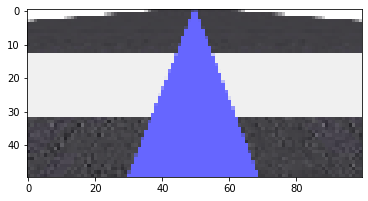

In [2]:
plt.imshow(images_simple[0])

(3550, 50, 100, 3)
[[[ 2.2489083   2.4285712   2.6399999 ]
  [ 2.2489083   2.4285712   2.6399999 ]
  [ 2.2489083   2.4285712   2.6399999 ]
  ...
  [ 2.2489083   2.4285712   2.6399999 ]
  [ 2.2489083   2.4285712   2.6399999 ]
  [ 2.2489083   2.4285712   2.6399999 ]]

 [[ 2.2489083   2.4285712   2.6399999 ]
  [ 2.2489083   2.4285712   2.6399999 ]
  [ 2.2489083   2.4285712   2.6399999 ]
  ...
  [ 2.2489083   2.4285712   2.6399999 ]
  [ 2.2489083   2.4285712   2.6399999 ]
  [ 2.2489083   2.4285712   2.6399999 ]]

 [[ 2.2489083   2.4285712   2.6399999 ]
  [ 2.2489083   2.4285712   2.6399999 ]
  [ 2.2489083   2.4285712   2.6399999 ]
  ...
  [ 2.2489083   2.4285712   2.6399999 ]
  [ 2.2489083   2.4285712   2.6399999 ]
  [ 2.2489083   2.4285712   2.6399999 ]]

 ...

 [[-1.0904187  -1.0028011  -0.688976  ]
  [-0.78217316 -0.687675   -0.39267972]
  [-0.9534207  -0.86274505 -0.56697166]
  ...
  [-1.2959157  -1.212885   -0.91555554]
  [-0.86779696 -0.77521    -0.47982568]
  [-0.8506722  -0.757703 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3550
[0.09063698 0.3127273 ]
[0.0043056  0.27766642]
[-0.02916494  0.26407337]
[-0.00802817  0.27265742]
[0.01144872 0.28056738]
[0.00066521 0.276188  ]
[-0.00153488  0.27529448]


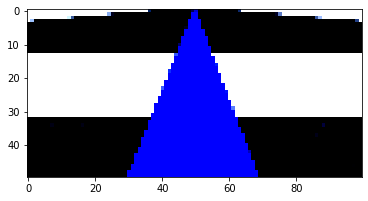

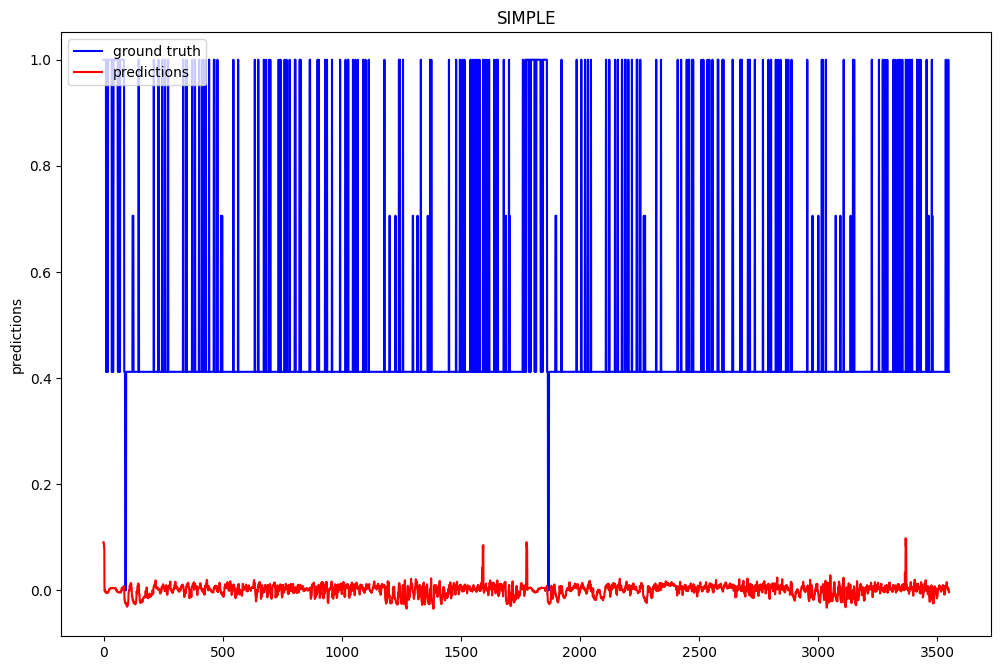

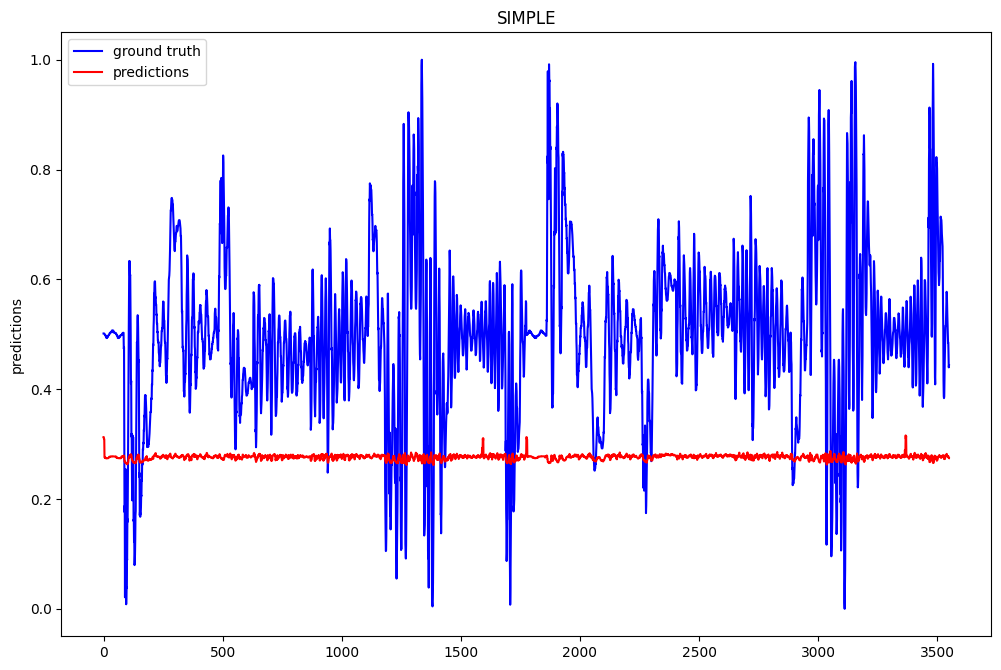

In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from albumentations import (
    Compose, HorizontalFlip, RandomBrightnessContrast, 
    HueSaturationValue, FancyPCA, RandomGamma, GaussNoise,
    GaussianBlur, ToFloat, Normalize
)


lstm_model = load_model('20210801-164236_deepest_lstm_tinypilotnet_pilotnet_model_300_all_crop_no_seq_unique_albu_extreme_seq_cp.h5')

AUGMENTATIONS_TEST = Compose([
    Normalize()
])



normalized_images = []
for img in images_simple:
    image = AUGMENTATIONS_TEST(image=img)['image']
    normalized_images.append(image)

normalized_images = np.stack(normalized_images, axis=0)

print(normalized_images.shape)
print(normalized_images[0])
predictions_train = lstm_model.predict(normalized_images)


print(len(predictions_train))

plt.imshow(normalized_images[0])
print(predictions_train[0])
print(predictions_train[50])
print(predictions_train[100])
print(predictions_train[200])
print(predictions_train[250])
print(predictions_train[450])
print(predictions_train[600])


#print(predictions_train[:,1])

#print(images_train[100])
#print(annotations_simple[100])


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_simple[:,0], "-b", label="ground truth")
plt.plot(predictions_train[:,0], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('SIMPLE')
plt.show()


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_simple[:,1], "-b", label="ground truth")
plt.plot(predictions_train[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('SIMPLE')
plt.show()


3550
3550


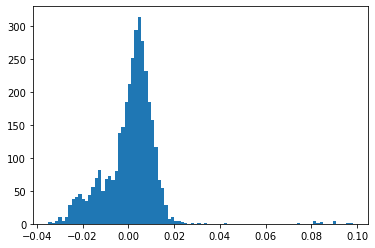

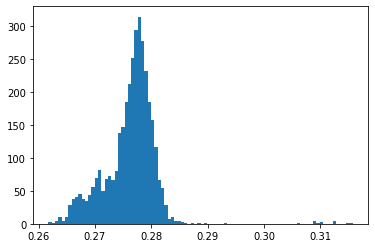

In [5]:
ann_x = []
ann_y = []
number = 0 
total_number = 0
for x, ann in enumerate(predictions_train):
    ann_x.append(ann[0])
    ann_y.append(ann[1])
    if float(ann[0]) <= 0.2:
        #print(x)
        number += 1
    total_number += 1
print(number)
print(total_number)

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()